<a href="https://colab.research.google.com/github/vincelemke99/Bachelor-Thesis/blob/main/lead_predication_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlens --q
!pip install pandas category_encoders scikit-learn --q


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Import machine learning libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

In [3]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [4]:
PROJECT_ID = 'prj-snd-ew3-vschmitt'

In [5]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

In [6]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'lead_prediction'
BQ_TABLE = 'trainings_data_raw'

In [7]:
# SQL query to select data
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""

try:
    # Execute the query and convert the result to a pandas DataFrame
    df = client.query(query=query).to_dataframe()
    print("Query executed successfully and DataFrame is ready.")
except Exception as e:
    print(f"An error occurred: {e}")

Query executed successfully and DataFrame is ready.


In [8]:
df.shape

(1451196, 26)

In [9]:
# Identify duplicate lead_ids
duplicate_lead_ids = df[df.duplicated('lead_id', keep=False)]['lead_id'].unique()

# Filter rows to drop
rows_to_drop = df[(df['lead_id'].isin(duplicate_lead_ids)) & (df['is_converted'] == False)]

# Drop rows
# Keep only unique lead_ids (this is optional if the above steps suffice)
df = df.drop_duplicates(subset='lead_id')

In [10]:
df.shape

(238933, 26)

In [11]:
df.head()

,lead_id,domain,name,has_phone,geschlecht,lead_source,lead_quelle_detail,produkt_zeitraum_c,produkt_art_der_ausbildung_c,product_interest_type,...,pagepath,time_OnSite,ManualTerm,Browser,Operating_System,Device,Language,Device_Category,ManualAdContent,bounce
0,00QbG000000Zp2tUAC,gmail.com,normal,True,weiblich,Paid SEM,Google Ads,Vollzeit,Master,Infoabend,...,https://www.hs-fresenius.de/termine/anmeldung/...,<NA>,None,None,None,None,None,None,None,None
1,00QbG000000vOP0UAM,gmx.de,normal,True,weiblich,Publisher,www.studieren-studium.com,Vollzeit,Bachelor,Infoabend,...,https://www.hs-fresenius.de/termine/anmeldung/...,0,responsive search ads,Chrome,Windows 10,Chrome,de-de,desktop,ads,false
2,00QbG0000010XBVUA2,gmx.de,normal,True,weiblich,Direkt,charlotte-fresenius-uni.de,Vollzeit,Bachelor,Infoabend,...,https://www.fernstudium-fresenius.de/lp/bachel...,0,responsive search ads,Chrome,Android 12.0.0,2109119DG,de,mobile,ads,true
3,00Q7U00000HvMypUAF,web.de,normal,False,weiblich,Referral,google.de,Vollzeit,Bachelor,Infoabend,...,https://www.hs-fresenius.de/termine/anmeldung/...,10552,responsive search ads,Firefox,Windows 10,Firefox,de,desktop,ads,false
4,00QbG0000013h9XUAQ,gmail.com,normal,False,weiblich,Publisher,privathochschulen.net,Vollzeit,Bachelor,Infoabend,...,https://www.hs-fresenius.de/termine/anmeldung/...,19790,responsive search ads,Chrome,Windows 10,Chrome,de-de,desktop,ads,false


In [12]:
df.drop(['lead_id',], axis="columns", inplace=True)

In [13]:
df.rename(columns={'name': 'Name_Describe','geschlecht' : 'Gender', 'produkt_zeitraum_c' : 'Study_Model',
       'produkt_art_der_ausbildung_c' : 'Type_of_Study_Program', 'produkt_standort' : 'Study_Location',
       'produkt_fachbereich' : 'Faculty', 'produkt_name': 'Study_Program','product_interest_type' : 'Conversion_Type',
       'lead_quelle_detail' : 'Lead_Source_Detail', 'domain': 'Domain', 'has_phone' : 'has_Phone', 'lead_source' : 'Lead_Source', 'pagepath': 'Pagepath', 'time_OnSite' : 'Time_on_Site' , 'bounce' : 'Bounce', 'semester':'Semester', 'host': 'Host'},inplace=True)
df.head()

,Domain,Name_Describe,has_Phone,Gender,Lead_Source,Lead_Source_Detail,Study_Model,Type_of_Study_Program,Conversion_Type,Study_Location,...,Pagepath,Time_on_Site,ManualTerm,Browser,Operating_System,Device,Language,Device_Category,ManualAdContent,Bounce
0,gmail.com,normal,True,weiblich,Paid SEM,Google Ads,Vollzeit,Master,Infoabend,Berlin,...,https://www.hs-fresenius.de/termine/anmeldung/...,<NA>,None,None,None,None,None,None,None,None
1,gmx.de,normal,True,weiblich,Publisher,www.studieren-studium.com,Vollzeit,Bachelor,Infoabend,Düsseldorf,...,https://www.hs-fresenius.de/termine/anmeldung/...,0,responsive search ads,Chrome,Windows 10,Chrome,de-de,desktop,ads,false
2,gmx.de,normal,True,weiblich,Direkt,charlotte-fresenius-uni.de,Vollzeit,Bachelor,Infoabend,Heidelberg,...,https://www.fernstudium-fresenius.de/lp/bachel...,0,responsive search ads,Chrome,Android 12.0.0,2109119DG,de,mobile,ads,true
3,web.de,normal,False,weiblich,Referral,google.de,Vollzeit,Bachelor,Infoabend,Wiesbaden,...,https://www.hs-fresenius.de/termine/anmeldung/...,10552,responsive search ads,Firefox,Windows 10,Firefox,de,desktop,ads,false
4,gmail.com,normal,False,weiblich,Publisher,privathochschulen.net,Vollzeit,Bachelor,Infoabend,Berlin,...,https://www.hs-fresenius.de/termine/anmeldung/...,19790,responsive search ads,Chrome,Windows 10,Chrome,de-de,desktop,ads,false


In [14]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
ManualTerm,167968
ManualAdContent,166352
Device,165211
Operating_System,164787
Browser,164787
Time_on_Site,164787
Language,164787
Device_Category,164787
Bounce,164787
Host,42988


In [15]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
ManualTerm,70.299205
ManualAdContent,69.622865
Device,69.145325
Operating_System,68.967870
Browser,68.967870
Time_on_Site,68.967870
Language,68.967870
Device_Category,68.967870
Bounce,68.967870
Host,17.991655


In [16]:
df['Study_Program'].value_counts()

Study_Program
Psychologie, B.Sc.                                                   38542
Betriebswirtschaftslehre, B.A.                                       11707
Soziale Arbeit, B.A.                                                 11263
Wirtschaftspsychologie, B.Sc.                                        11098
Physiotherapie, B.Sc.                                                 7796
                                                                     ...  
Wirtschaftsingenieurwesen Engineering und Automatisierung, M.Eng.        1
Insurance Management & Finance, M.Sc.                                    1
Master of Management in Artificial Intelligence, Economy, MMAI           1
Projektmanagement, MA - 60 ETCS                                          1
Angewandte Psychologie für Führungskräfte, M.A. weiterbildend            1
Name: count, Length: 219, dtype: int64

In [17]:
df['Study_Program'] = df['Study_Program'].fillna('Psychologie, B.Sc.')

In [18]:
df['Study_Model'].value_counts()

Study_Model
Vollzeit            128942
Blended Learning     72634
Berufsbegleitend     31309
Duales Studium        5373
Mixed Mode             675
Name: count, dtype: int64

In [19]:
  # Replace "Duales Studium" and "Mixed Mode" with "Berufsbegleitend"
df['Study_Model'] = df['Study_Model'].replace({
        'Duales Studium': 'Berufsbegleitend',
        'Mixed Mode': 'Berufsbegleitend'
  })

In [20]:
df['Device_Category'].value_counts()

Device_Category
mobile     47787
desktop    25416
tablet       943
Name: count, dtype: int64

In [21]:
df['Semester'] = df['Semester'].fillna('Wintersemester')
df['Lead_Source_Detail'] = df['Lead_Source_Detail'].fillna('Google Ads')
df['Domain'] = df['Domain'].fillna('gmail.com')
df['Gender'] = df['Gender'].fillna('weiblich')
df['Conversion_Type'] = df['Conversion_Type'].fillna('Infomaterial')
df['Pagepath'] = df['Pagepath'].fillna('https://www.hs-fresenius.de/infomaterial/')
df['Operating_System'] = df['Operating_System'].fillna('Windows 10')
df['Browser'] = df['Browser'].fillna('Safari')
df['Language'] = df['Language'].fillna('de-de')
df['Device_Category'] = df['Device_Category'].fillna('mobile')
df['Bounce'] = df['Bounce'].fillna('true')
df['ManualAdContent'] = df['ManualAdContent'].fillna('ads')
df['ManualTerm'] = df['ManualTerm'].fillna('responsive search ads')
df['Faculty'] = df['Faculty'].fillna('Fachbereich onlineplus')
df['has_Phone'] = df['has_Phone'].fillna(False)
df['Host'] = df['Host'].fillna('www.hs-fresenius.de')
df['Device'] = df['Device'].fillna('iPhone')


In [22]:
df.describe()

,Time_on_Site
count,74146.0
mean,2685.797427
std,8161.453173
min,0.0
25%,0.0
50%,36.0
75%,537.0
max,83521.0


In [23]:
df['Time_on_Site'] = df['Time_on_Site'].fillna(36)

In [24]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Domain,0
Name_Describe,0
has_Phone,0
Gender,0
Lead_Source,0
Lead_Source_Detail,0
Study_Model,0
Type_of_Study_Program,0
Conversion_Type,0
Study_Location,0


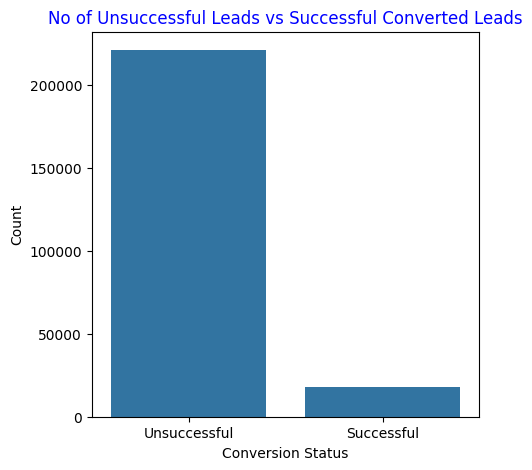

In [25]:
plt.figure(figsize=(5,5))
sns.countplot(x='is_converted', data=df)
plt.title('No of Unsuccessful Leads vs Successful Converted Leads', color='blue')
plt.xticks(np.arange(2), ('Unsuccessful', 'Successful'))
plt.xlabel('Conversion Status')
plt.ylabel('Count')
plt.show()

In [26]:
total_leads = len(df)
successful_leads = df['is_converted'].sum()
conversion_rate = (successful_leads / total_leads) * 100
print(f'Conversion Rate: {conversion_rate:.2f}%')

Conversion Rate: 7.54%


In [27]:
# Creating a crosstab DataFrame for demonstration
crosstab_df = pd.crosstab(index=df['Lead_Source'], columns='count')

In [28]:

def plot_frequency_and_percentage(feature, df, category_df, another_row=False, height=8, ylabels=[]):
    if another_row:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, height * 2))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Get top 5 categories by frequency
    top_categories = category_df[feature].value_counts().nlargest(5).index

    # Frequency plot for top 5 categories
    ax1.set_title(f'Frequency Plot of {feature}', color='blue')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('count')
    sns.countplot(y=feature, data=category_df[category_df[feature].isin(top_categories)],
                  order=top_categories, ax=ax1, color='green')
    if ylabels:
        ax1.set_yticklabels(ylabels)

    # Calculate count of converted leads for top 5 categories
    converted_counts = df[df['is_converted'] == True][feature].value_counts()
    converted_counts = converted_counts[converted_counts.index.isin(top_categories)]

    # Converted leads plot for top 5 categories
    ax2.set_title('Converted Leads Count', color='blue')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('count')
    converted_counts.sort_values().plot(kind='barh', ax=ax2, color='orange')
    if ylabels:
        ax2.set_yticklabels(ylabels)

    # Calculate and display overall conversion rate
    total_leads = len(df)
    successful_leads = df['is_converted'].sum()
    conversion_rate = (successful_leads / total_leads) * 100
    fig.suptitle(f'Overall Conversion Rate: {conversion_rate:.2f}%', fontsize=14, color='red')


plt.show()

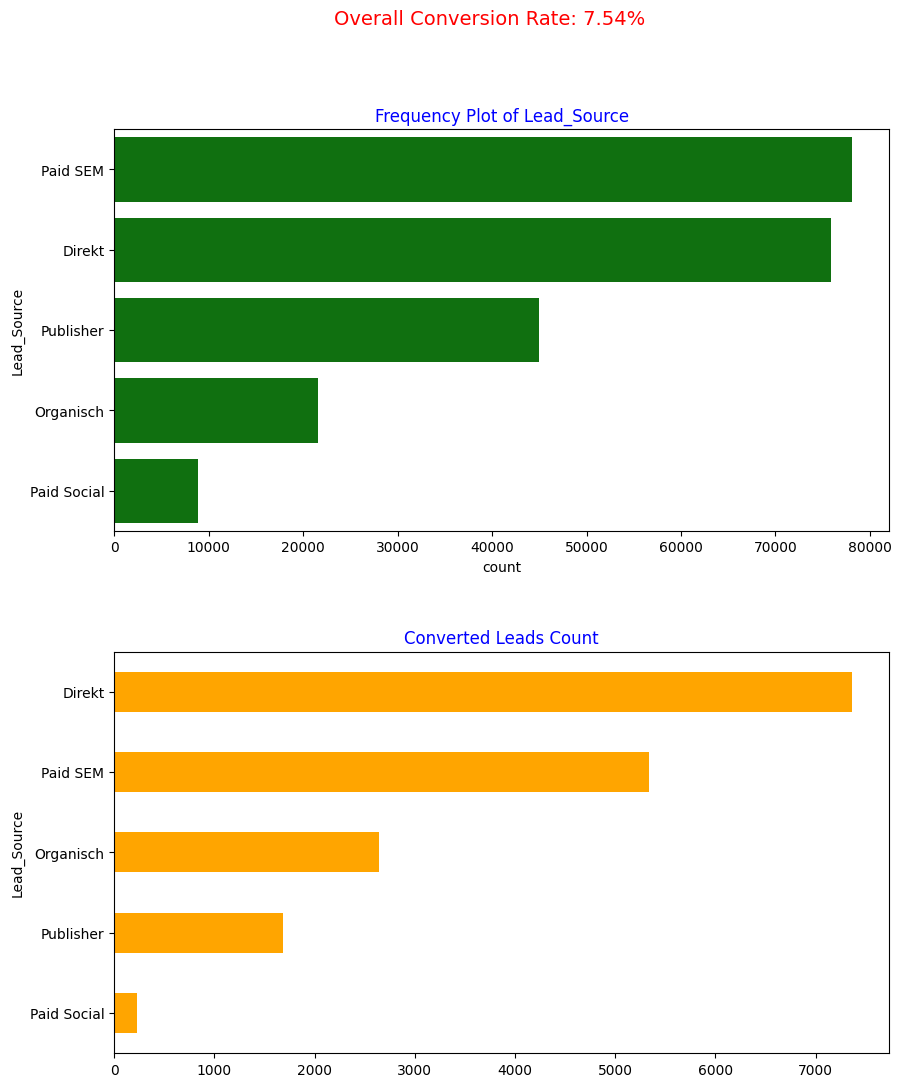

In [29]:
plot_frequency_and_percentage('Lead_Source', df, df, True, 6)

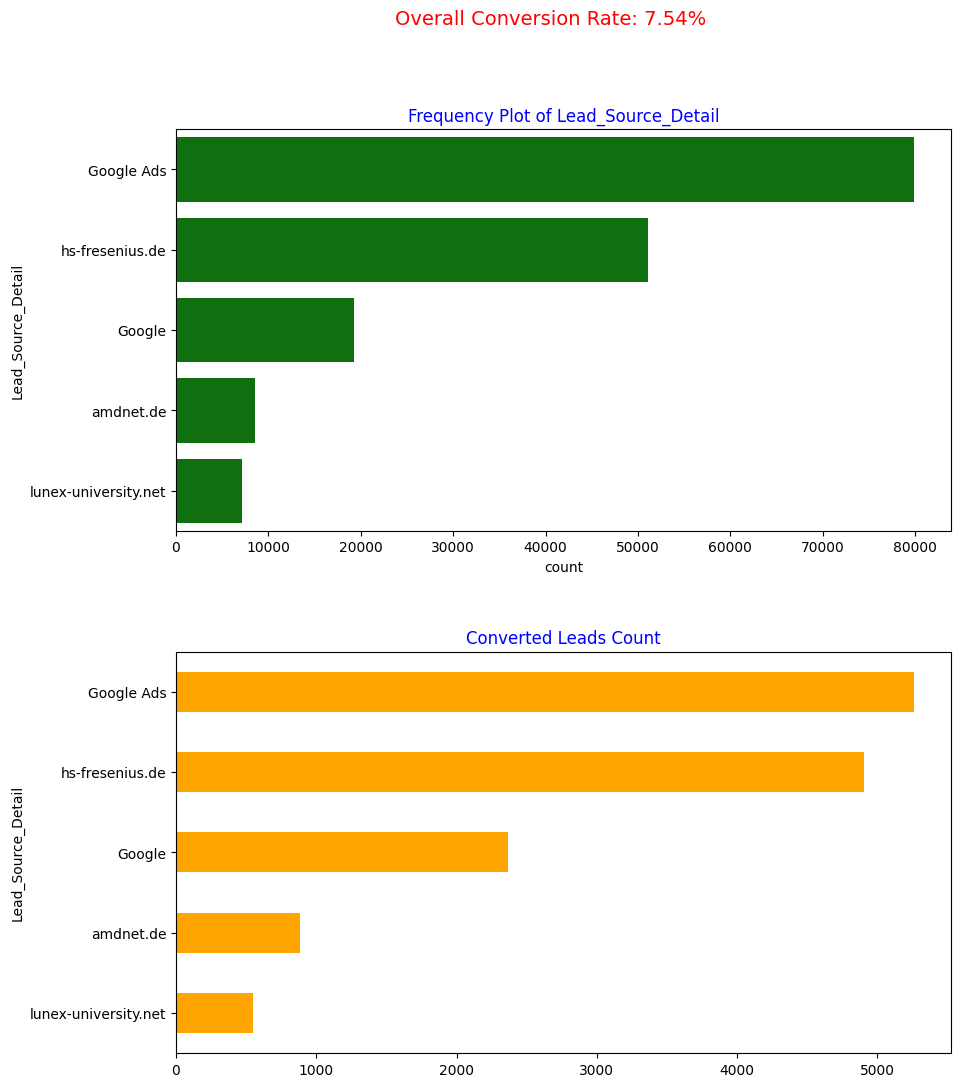

In [30]:
plot_frequency_and_percentage('Lead_Source_Detail', df, df, True, 6)

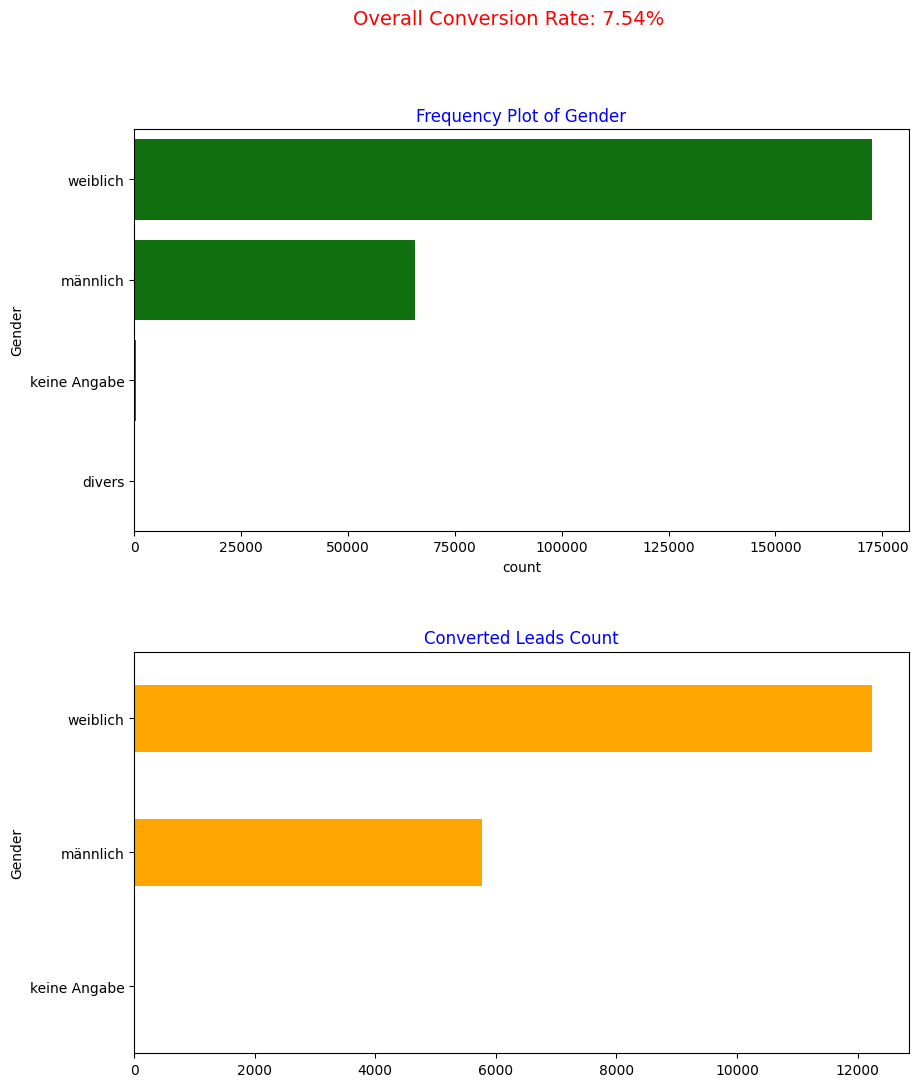

In [31]:
plot_frequency_and_percentage('Gender', df, df, True, 6)

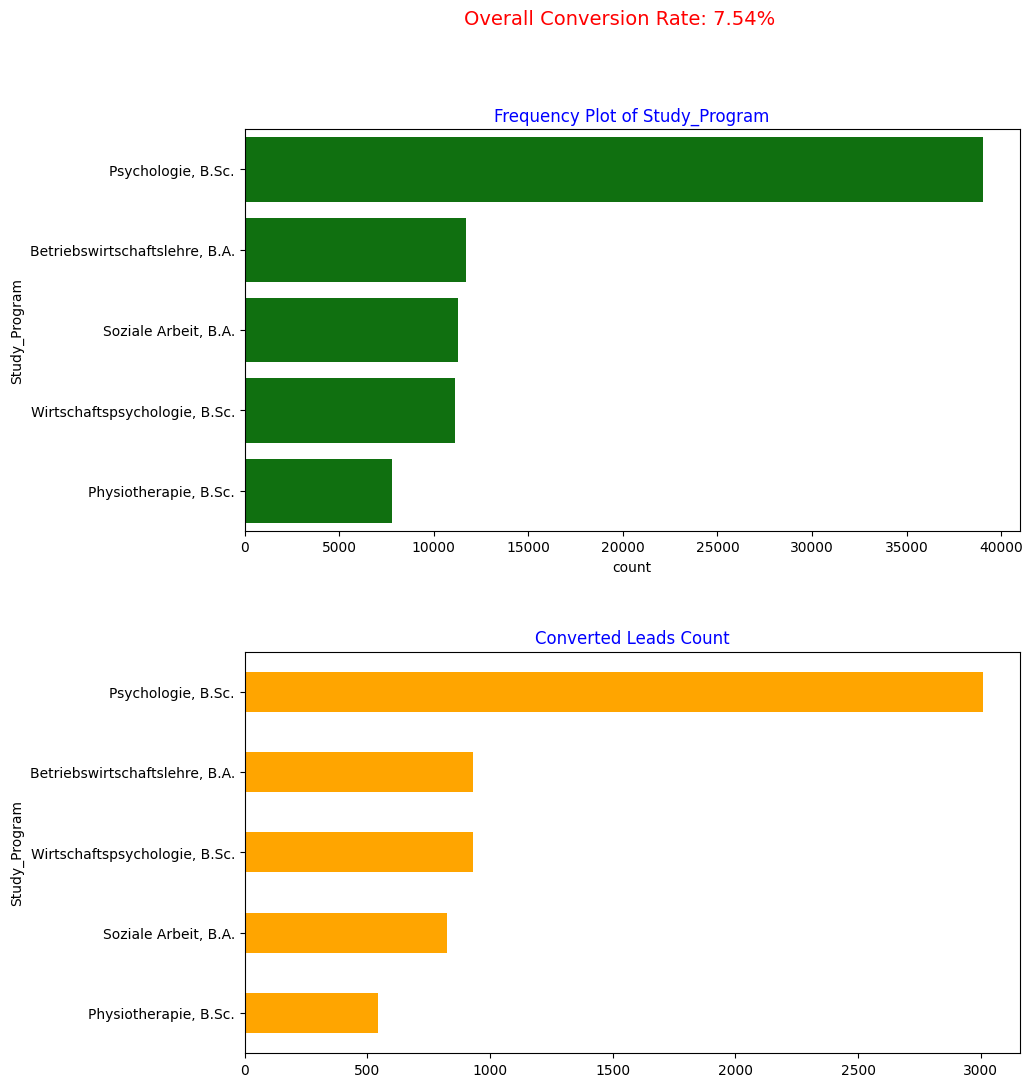

In [32]:
plot_frequency_and_percentage('Study_Program', df, df, True, 6)

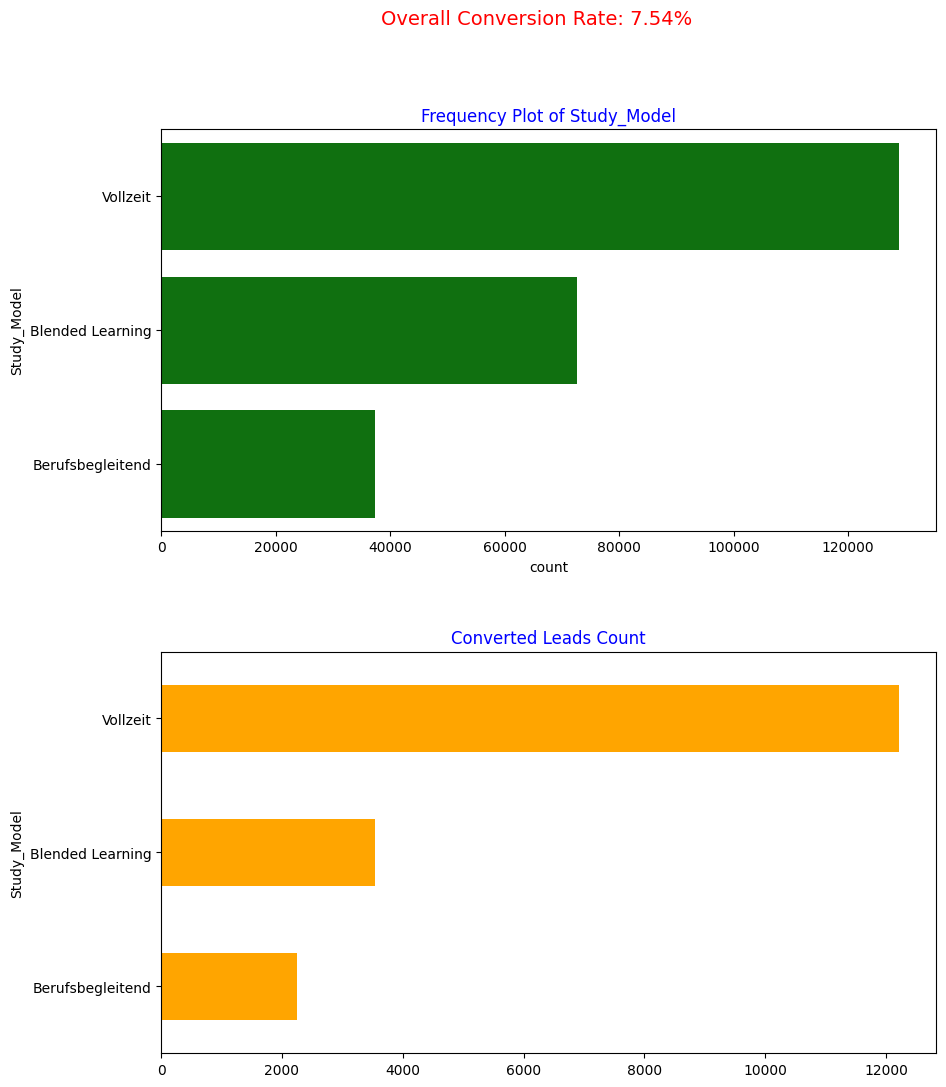

In [33]:
plot_frequency_and_percentage('Study_Model', df, df, True, 6)

In [34]:
# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder, StandardScaler
import category_encoders as ce

In [35]:
df.dtypes

Domain                    object
Name_Describe             object
has_Phone                boolean
Gender                    object
Lead_Source               object
Lead_Source_Detail        object
Study_Model               object
Type_of_Study_Program     object
Conversion_Type           object
Study_Location            object
Faculty                   object
Study_Program             object
Semester                  object
is_converted             boolean
Host                      object
Pagepath                  object
Time_on_Site               Int64
ManualTerm                object
Browser                   object
Operating_System          object
Device                    object
Language                  object
Device_Category           object
ManualAdContent           object
Bounce                    object
dtype: object

In [36]:
df.nunique()

Domain                   11470
Name_Describe                3
has_Phone                    2
Gender                       4
Lead_Source                 26
Lead_Source_Detail         582
Study_Model                  3
Type_of_Study_Program        6
Conversion_Type              2
Study_Location              20
Faculty                     10
Study_Program              219
Semester                     2
is_converted                 2
Host                        18
Pagepath                 48348
Time_on_Site               675
ManualTerm                  16
Browser                      9
Operating_System            70
Device                     193
Language                    36
Device_Category              3
ManualAdContent             47
Bounce                       2
dtype: int64

In [37]:
# Create a copy of the dataframe to work with
df_encoded = df.copy()

# Step 1: Drop 'is_converted' column from df_encoded and assign to X_
X = df_encoded.drop(columns=['is_converted'])

# Step 2: Extract 'is_converted' column from df_encoded and assign to y
y = df_encoded['is_converted']

In [38]:
# Step 3: Label Encoding for specified columns
label_features = ['has_Phone', 'Conversion_Type', 'Semester', 'Bounce']
label_encoder = LabelEncoder()
for col in label_features:
    X[col] = label_encoder.fit_transform(X[col])

# Step 4: Binary Encoding for specified columns
binary_features = ['Pagepath', 'Domain']
encoder_target = ce.TargetEncoder(cols=binary_features)
X = encoder_target.fit_transform(X, y)

# Step 5: Frequency/Count Encoding for specified columns
one_hot_features = [
    'Lead_Source', 'Lead_Source_Detail', 'Study_Location', 'Faculty',
    'Study_Program', 'Host', 'ManualTerm', 'Operating_System', 'Device',
    'Language', 'ManualAdContent', 'Name_Describe', 'Gender', 'Study_Model',
    'Type_of_Study_Program', 'Browser', 'Device_Category'
]
'''
for col in count_features:
    count_encoding = X[col].one_ho()
    X[col] = X[col].map(count_encoding)
'''
X = pd.get_dummies(X, columns=one_hot_features)

# Step 6: Scaling the dataframe
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Step 7: Define the encoded and scaled dataframe as X_prep
X_en = df_scaled

In [40]:
# Define categorical features indices for SMOTENC, excluding 'Time_on_Site'
#categorical_columns = [X_en.columns.get_loc(col) for col in label_features + binary_features + one_hot_features]
#print(categorical_columns)

In [41]:
lb = LabelEncoder()
lb.fit(y)
y_encoded = lb.transform(y)
print("Encoded labels:",lb.classes_)
y_en = pd.Series(y_encoded)

Encoded labels: [0. 1.]


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_en, y_en, test_size=0.2, stratify=y, random_state=42)


print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_test.shape, y_test.shape)

Training Data Shape :  (191146, 1272) (191146,)
Test Data Shape :  (47787, 1272) (47787,)


In [43]:
#smotenc = SMOTENC(categorical_features=categorical_columns, random_state=42)
#X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train, y_train)
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks

#tomek = TomekLinks()
#X_train, y_train = tomek.fit_resample(X_train, y_train)
borderline_smote = BorderlineSMOTE(random_state=42)
X_train, y_train = borderline_smote.fit_resample(X_train, y_train)



In [44]:
print("Smote Train Data : ", X_train.shape, y_train.shape)

Smote Train Data :  (353470, 1272) (353470,)


In [46]:
X_train_resampled_dropped = X_train.drop(columns=['Time_on_Site'])

mi_classification = mutual_info_classif(X_train, y_train, discrete_features='auto')

# Create a pandas Series with the MI scores and the feature names
mi_series = pd.Series(mi_classification, index=X.columns)

# Sort the MI scores in descending order and convert to a DataFrame
data_mi = mi_series.sort_values(ascending=False).to_frame(name='MI')

# Display the DataFrame
print(data_mi)

KeyboardInterrupt: 

In [ ]:
# Function to plot the Mutual Information scores
def plot_mi_scores(scores):
    sorted_scores = scores.sort_values(ascending=True)
    width = np.arange(len(sorted_scores))
    ticks = sorted_scores.index
    plt.barh(width, sorted_scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.xlabel("Score")
    plt.ylabel("Features")
    plt.show()

# Plot the Mutual Information scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_series)


In [ ]:
correlation_value = X_train['Time_on_Site'].corr(y_train)
correlation_df = pd.DataFrame({'Correlations': [correlation_value]})
print(correlation_df)

In [ ]:
filtered_data_mi = data_mi[data_mi['MI'] > 0.02]

X_train = X_train[filtered_data_mi.index]
X_test= X_test[filtered_data_mi.index]



In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
cv_split = StratifiedKFold(n_splits=10)

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, proba)

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # Cross Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"F1-Score: {f1}")
    print(f"Specificity: {specificity}")
    print(f"ROC AUC: {roc_auc}")
    print(f"Cross Validation Accuracy: {cv_scores.mean()}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix Visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'cv_accuracy': cv_scores.mean()
    }


In [ ]:
# Pipelines for each model without hyperparameter tuning
pipeline_lgb = Pipeline([

    ('clf', lgb.LGBMClassifier(objective='binary', metric='binary_error'))
])

pipeline_xgb = Pipeline([
    ('clf', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'))
])

pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier())
])


pipeline_dt = Pipeline([
    ('clf', DecisionTreeClassifier())
])



In [ ]:
# Dictionary to store evaluation results
model_performance = {}

# Train and evaluate LightGBM
model_performance['LightGBM'] = evaluate_model(pipeline_lgb.fit(X_train, y_train), X_test, y_test, "LightGBM")

# Train and evaluate XGBoost
model_performance['XGBoost'] = evaluate_model(pipeline_xgb.fit(X_train, y_train),X_test, y_test, "XGBoost")

# Train and evaluate RandomForest
model_performance['RandomForest'] = evaluate_model(pipeline_rf.fit(X_train, y_train), X_test, y_test, "RandomForest")

# Train and evaluate DecisionTree
model_performance['DecisionTree'] = evaluate_model(pipeline_dt.fit(X_train, y_train), X_test, y_test, "DecisionTree")


# Determine the best model based on ROC AUC
best_model_name = max(model_performance, key=lambda k: model_performance[k]['roc_auc'])
print(f"The best model is {best_model_name} based on ROC AUC.")


In [ ]:
# Assuming LightGBM was the best model based on initial evaluation
if best_model_name == 'LightGBM':
    param_dist = {
        'clf__num_leaves': range(20, 150, 10),
        'clf__max_depth': range(5, 30, 5),
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.15],
        'clf__n_estimators': range(50, 300, 50)
    }

    pipeline_best = Pipeline([

        ('clf', lgb.LGBMClassifier(objective='binary', metric='binary_error'))
    ])
elif best_model_name == 'XGBoost':
    param_dist = {
        'clf__max_depth': range(3, 10, 2),
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.15],
        'clf__n_estimators': range(50, 300, 50),
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0]
    }

    pipeline_best = Pipeline([

        ('clf', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'))
    ])
elif best_model_name == 'RandomForest':
    param_dist = {
        'clf__n_estimators': range(50, 300, 50),
        'clf__max_features': ['auto', 'sqrt', 'log2'],
        'clf__max_depth': range(5, 30, 5),
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__bootstrap': [True, False]
    }

    pipeline_best = Pipeline([
        ('clf', RandomForestClassifier())
    ])


    pipeline_best = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier())
    ])
elif best_model_name == 'DecisionTree':
    param_dist = {
        'clf__max_depth': range(5, 30, 5),
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__criterion': ['gini', 'entropy']
    }

    pipeline_best = Pipeline([
        ('clf', DecisionTreeClassifier())
    ])

random_search = RandomizedSearchCV(estimator=pipeline_best,
                                   param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Train and evaluate with best parameters from RandomizedSearchCV
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_
best_model_random.fit(X_train, y_train)
evaluate_model(best_model_random, X_test, y_test, f"{best_model_name} with RandomizedSearchCV Hyperparameter Tuning")
